In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.sfh as sfh
import torchvision
import gpytorch
import torch
from duste.DustAttnCalc import DustAttnCalc
import duste.DustAttnCalc as dd
import lbg_forecast.dust_priors as dp

from uncertainties import ufloat
from uncertainties.umath import log
from uncertainties import unumpy
import scipy as sc

In [2]:
import lbg_forecast.priors_gp_dust as gpdp
dust_prior = gpdp.DustPrior()

Loading Models
Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_small.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_HB.dat
Measured grid length from file: 5
Mins: {'logM': 8.74, 'sfr': -2.06, 'logZ': -1.7, 'z': 0.51, 'i': 0.09, 'd1': 0.01, 'd2': 0.01, 'de': 0.01}
Maxs: {'logM': 11.3, 'sfr': 2.11, 'logZ': 0.18, 'z': 2.83, 'i': 0.97, 'd1': 2.23, 'd2': 1.95, 'de': 2.19}
Marginalizing over z
Marginalizing over i
Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_ef

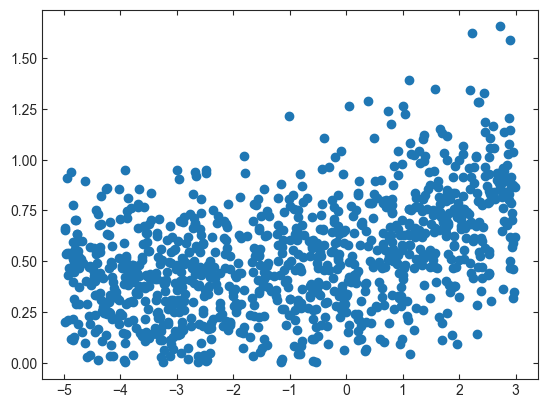

In [89]:
test_sfrs = np.random.uniform(-5, 3, 1000)
dust2samples = dust_prior.evaluate_dust2(test_sfrs, 0, 4, 0.05, 0.5)
plt.scatter(test_sfrs, dust2samples)

nsamples = 10000
popcosmos_samples = np.load("dust_data/popcosmos_parameters_rmag_lt_25.npy")[:nsamples, :]

dust_samples = popcosmos_samples[:, 8:11]
logsfrratios = popcosmos_samples[:, 2:8]
redshifts = popcosmos_samples[:, -1]
logmasses = popcosmos_samples[:, 0]
recent_sfrs = np.log10(sfh.calculate_recent_sfr(redshifts, 10**logmasses, logsfrratios))

dust2 = dust_samples[:, 0]
dust_index = dust_samples[:, 1]
dust1frac = dust_samples[:, 2]
dust1 = dust1frac*dust2

alpha=0.5
f, ax = plt.subplots(3, 1, figsize=(15, 20))
ax[0].scatter(dust2, dust_index, c='k', alpha=0.5)
ax[1].scatter(dust1, dust2, c='k', alpha=0.5)
ax[2].scatter(recent_sfrs, dust2, c='k', alpha=0.5)

In [2]:
def create_gp_model(lengthscale, train_x, train_y):

    class GPModel(gpytorch.models.ExactGP):

        def __init__(self, train_x, train_y, likelihood):
            super(GPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(lengthscale[0], lengthscale[1])))

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood).to(torch.double)

    return model, likelihood

def create_gp_model_obs(lengthscale, train_x, train_y, noise):

    class GPModel(gpytorch.models.ExactGP):

        def __init__(self, train_x, train_y, likelihood):
            super(GPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(lengthscale[0], lengthscale[1])))

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noise)
    model = GPModel(train_x, train_y, likelihood).to(torch.double)

    return model, likelihood

def gp_training_loop(model, likelihood, train_x, train_y, training_iter, lr=1e-4):

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            #i + 1, training_iter, loss.item(),
        print(loss.item())
            #model.likelihood.noise.item()
        #))
        optimizer.step()

    return model, likelihood

def gp_evaluate_model(model, likelihood, test_x):
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()
    f_preds = model(test_x.to(torch.double))

    return f_preds

def gp_plot_confidence(f_preds, test_x, train_x, train_y, labelx, labely, alpha=0.5):

    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(10, 7))

        # Get upper and lower confidence bounds
        lower, upper = f_preds.confidence_region()
        # Plot training data as black stars
        ax.scatter(train_x.numpy(), train_y.numpy(), c='k', alpha=alpha)
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), f_preds.mean, 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
        #ax.legend(['Observed Data', 'Mean', 'Confidence'])

        ax.set_xlabel(labelx)
        ax.set_ylabel(labely)


def gp_plot_confidence_obs(f_preds, test_x, train_x, train_y, train_yerrs, labelx, labely, alpha=0.5):

    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(10, 7))

        # Get upper and lower confidence bounds
        lower, upper = f_preds.confidence_region()
        # Plot training data as black stars
        ax.errorbar(train_x.numpy(), train_y.numpy(), train_yerrs.numpy(), fmt='ko', capsize=2)
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), f_preds.mean, 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
        #ax.legend(['Observed Data', 'Mean', 'Confidence'])

        ax.set_xlabel(labelx)
        ax.set_ylabel(labely)

def binned_weighted_mean_std(x, y, yerr, bins):

    bin_midpoints = (bins[:-1]+bins[1:])/2
    nbins = len(bins)-1
    bin_indexes = np.digitize(x, bins)-1

    weighted_averages = []
    error = []
    non_empty_bins = []
    for bin in range(nbins):

        y_indexes = np.where(bin_indexes == bin)[0]

        if(len(y_indexes)> 0):
            y_in_bin = y[y_indexes]
            yerrs_in_bin = yerr[y_indexes]
            weights_in_bin = (1/yerrs_in_bin)**2
            weighted_average_in_bin = np.average(y_in_bin, weights=weights_in_bin)
            #error_on_wmean = np.sqrt(1/np.sum(weights_in_bin))
            std_in_bin = np.std(y_in_bin)
            avg_err_in_bin = np.mean(yerrs_in_bin)
            weighted_averages.append(weighted_average_in_bin)
            #set error floor
            if(std_in_bin<avg_err_in_bin):
                error.append(avg_err_in_bin)
            else:
                error.append(std_in_bin)
            non_empty_bins.append(bin_midpoints[bin])

    return np.array(non_empty_bins), np.array(weighted_averages), np.array(error)

train_sfrs = torch.from_numpy(recent_sfrs)
train_dust2 = torch.from_numpy(dust2)
test_sfrs = torch.linspace(-5, 3, 100)
model, likelihood = create_gp_model([3.0, 15.0], train_sfrs, train_dust2)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_sfrs, train_dust2, training_iter=100, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_sfrs)
gp_plot_confidence(f_preds, test_sfrs, train_sfrs, train_dust2, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    #arr = unumpy.uarray(f_preds.mean.numpy(), f_preds.stddev.numpy())
    #arr = unumpy.exp(arr)
    #means = unumpy.nominal_values(arr)
    #stds = unumpy.std_devs(arr)
    means = f_preds.mean.numpy()
    stds = f_preds.stddev.numpy()

plt.errorbar(test_sfrs, means, stds)
plt.scatter(train_sfrs.numpy(), train_dust2.numpy(), c='k', alpha=alpha)

with torch.no_grad():
    for i in range(100):
        plt.plot(test_sfrs, f_preds.sample().numpy(), c='purple', alpha=0.5)

plt.scatter(train_sfrs.numpy(), train_dust2.numpy(), c='k', alpha=alpha)

train_dust2 = torch.from_numpy(dust2)
train_dust_index = torch.from_numpy(dust_index)
test_dust2 = torch.linspace(0, 4, 100)
model, likelihood = create_gp_model([2.0, 6.0], train_dust2, train_dust_index)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_dust2, train_dust_index, training_iter=100, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_dust2)
gp_plot_confidence(f_preds, test_dust2, train_dust2, train_dust_index, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    means = f_preds.mean.numpy()
    stds = f_preds.stddev.numpy()

plt.errorbar(test_dust2, means, stds)
plt.scatter(train_dust2.numpy(), train_dust_index.numpy(), c='k', alpha=alpha)

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.5)

plt.scatter(train_dust2.numpy(), train_dust_index.numpy(), c='k', alpha=alpha)

train_dust2 = torch.from_numpy(dust2)
train_dust1 = torch.from_numpy(dust1)
test_dust2 = torch.linspace(0, 4, 100)
model, likelihood = create_gp_model([2.0, 6.0], train_dust2, train_dust1)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_dust2, train_dust1, training_iter=100, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_dust2)
gp_plot_confidence(f_preds, test_dust2, train_dust2, train_dust1, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    means = f_preds.mean.numpy()
    stds = f_preds.stddev.numpy()

plt.errorbar(test_dust2, means, stds)
plt.scatter(train_dust2.numpy(), train_dust1.numpy(), c='k', alpha=alpha)

d2 = np.linspace(0.1,4.0,50)
dobj = DustAttnCalc()
d1sim, _ = dobj.get_d1(d2)
d1, d1e = np.average(d1sim, axis=0), np.std(d1sim, axis=0)
print("d1 values:", d1)
print("d1e values:", d1e)

plt.errorbar(d2, d1, d1e)

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.5)

plt.scatter(train_dust2.numpy(), train_dust1.numpy(), c='k', alpha=alpha)

In [3]:
ngal = 20000
#sfrsamples = np.random.uniform(-8, 2, ngal)
logM = np.random.uniform(8.74,11.30,ngal)
sfr = np.random.uniform(-2.06,2.11,ngal)
logZ = np.random.uniform(-1.70,0.18,ngal)
dobj = DustAttnCalc(sfr=sfr, logM=logM, logZ=logZ, bv=True, eff=False)
dac, dac1, n, tau, tau1, ne, taue, tau1e = dobj.calcDust(max_num_plot=0)

Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_small.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_HB.dat
Measured grid length from file: 5
Mins: {'logM': 8.74, 'sfr': -2.06, 'logZ': -1.7, 'z': 0.51, 'i': 0.09, 'd1': 0.01, 'd2': 0.01, 'de': 0.01}
Maxs: {'logM': 11.3, 'sfr': 2.11, 'logZ': 0.18, 'z': 2.83, 'i': 0.97, 'd1': 2.23, 'd2': 1.95, 'de': 2.19}
Marginalizing over z
Marginalizing over i
Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20_HB.dat
M

mean: 0.05312956846033254 std: 0.006092479554434678
[-2.25 -1.75 -1.25 -0.75 -0.25  0.25  0.75  1.25  1.75  2.25] [0.58444608 0.57717064 0.57286322 0.56640845 0.55397729 0.63246629
 0.75676243 0.88964354 1.02505811 1.10899197] [0.11839041 0.12378922 0.14245346 0.15884343 0.17179472 0.21111102
 0.18585152 0.14250195 0.13206658 0.13917249]


<ErrorbarContainer object of 3 artists>

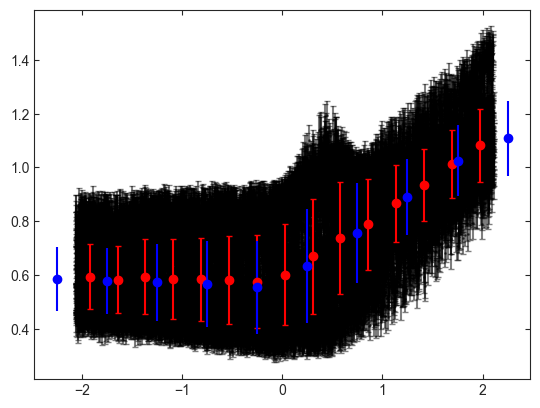

In [4]:
print("mean:", np.mean(taue), "std:", np.std(taue))
plt.errorbar(sfr, tau, taue, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)
bin_means_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(sfr, tau, 'mean', 15)
bin_std_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(sfr, tau, 'std', 15)
bin_width_de = (bin_edges_de[1] - bin_edges_de[0])
bin_centers_de = bin_edges_de[1:] - bin_width_de/2

plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
sfr_bins = np.arange(-3, 3, 0.5)
x, y, yerr = binned_weighted_mean_std(sfr, tau, taue, sfr_bins)
print(x, y, yerr)
plt.errorbar(x, y, yerr, fmt='bo')

<ErrorbarContainer object of 3 artists>

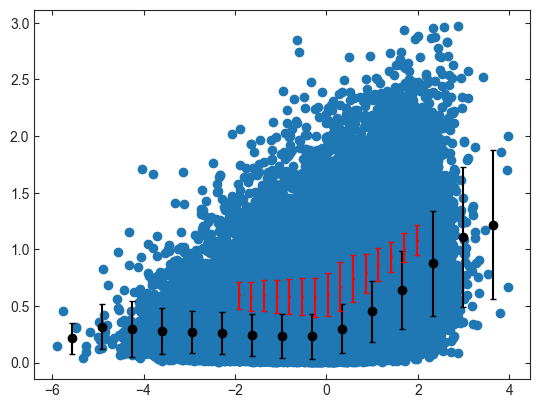

In [5]:
#sfrsamples = np.linspace(-8, 2, 20)
#dobj = DustAttnCalc(sfr=sfrsamples, bv=True, eff=False)
#dac, dac1, n, tau, tau1, ne, taue, tau1e = dobj.calcDust(max_num_plot=0)

nsamples = 500000
popcosmos_samples = np.load("dust_data/popcosmos_parameters_rmag_lt_25.npy")[:nsamples, :]

dust_samples = popcosmos_samples[:, 8:11]
logsfrratios = popcosmos_samples[:, 2:8]
redshifts = popcosmos_samples[:, -1]
logmasses = popcosmos_samples[:, 0]
recent_sfrs = np.log10(sfh.calculate_recent_sfr(redshifts, 10**logmasses, logsfrratios))

dust2 = dust_samples[:, 0]
dust_index = dust_samples[:, 1]
dust1frac = dust_samples[:, 2]
dust1 = dust1frac*dust2

plt.scatter(recent_sfrs, dust2)

bin_means, bin_edges, binnumber = sc.stats.binned_statistic(recent_sfrs, dust2,'mean', 15)
bin_std, bin_edges, binnumber = sc.stats.binned_statistic(recent_sfrs, dust2,'std', 15)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

tensor([-5.5679, -4.9106, -4.2534, -3.5961, -2.9389, -2.2817, -1.6244, -0.9672,
        -0.3099,  0.3473,  1.0046,  1.6618,  2.3190,  2.9763,  3.6335, -1.9210,
        -1.6430, -1.3651, -1.0871, -0.8092, -0.5312, -0.2533,  0.0247,  0.3027,
         0.5806,  0.8586,  1.1365,  1.4145,  1.6924,  1.9704],
       dtype=torch.float64) tensor([0.2137, 0.3149, 0.2967, 0.2761, 0.2670, 0.2581, 0.2462, 0.2343, 0.2301,
        0.2995, 0.4522, 0.6405, 0.8761, 1.1074, 1.2185, 0.5935, 0.5829, 0.5930,
        0.5844, 0.5833, 0.5818, 0.5753, 0.6014, 0.6690, 0.7386, 0.7881, 0.8667,
        0.9350, 1.0133, 1.0820], dtype=torch.float64) tensor([0.1363, 0.1995, 0.2458, 0.2019, 0.1860, 0.1857, 0.1848, 0.1912, 0.1973,
        0.2192, 0.2672, 0.3478, 0.4643, 0.6180, 0.6576, 0.1215, 0.1247, 0.1390,
        0.1475, 0.1550, 0.1649, 0.1717, 0.1878, 0.2147, 0.2077, 0.1702, 0.1432,
        0.1336, 0.1275, 0.1351], dtype=torch.float64)
1823.2076049267632
1767.1290826634358
1709.2239387993593
1649.6183627319704
1588.

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


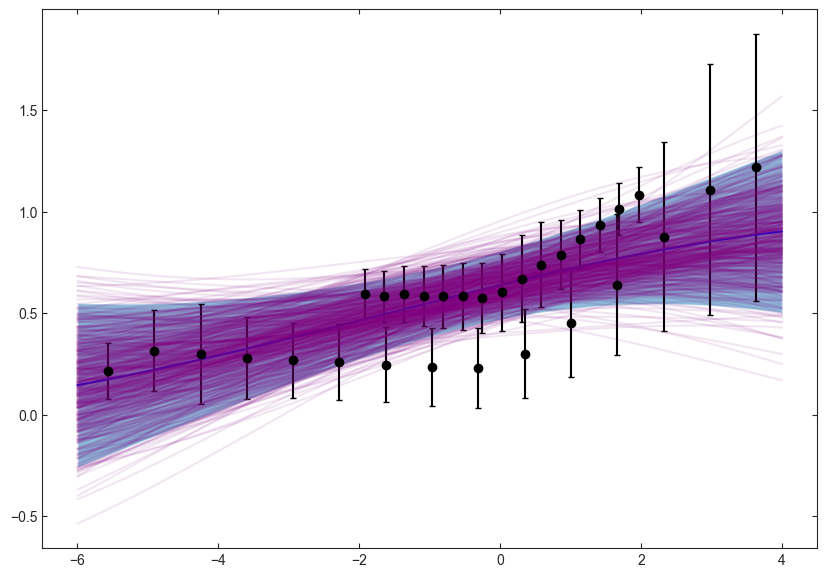

In [6]:
train_sfrs = torch.from_numpy(np.hstack((bin_centers, bin_centers_de)))
train_dust2 = torch.from_numpy(np.hstack((bin_means, bin_means_de)))
train_dust2_errs = torch.from_numpy(np.hstack((bin_std, bin_std_de)))

train_sfrs = torch.from_numpy(np.delete(train_sfrs.numpy(), np.where(np.isnan(train_dust2)==1)[0]))
train_dust2_errs = torch.from_numpy(np.delete(train_dust2_errs.numpy(), np.where(np.isnan(train_dust2)==1)[0]))
train_dust2 = torch.from_numpy(np.delete(train_dust2.numpy(), np.where(np.isnan(train_dust2)==1)[0]))

print(train_sfrs, train_dust2, train_dust2_errs)

test_sfrs = torch.linspace(-6, 4, 100)

model, likelihood = create_gp_model_obs([4.0, 10.0], train_sfrs, train_dust2, train_dust2_errs)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_sfrs, train_dust2, training_iter=20000, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_sfrs)
gp_plot_confidence_obs(f_preds, test_sfrs, train_sfrs, train_dust2, train_dust2_errs, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(500):
        plt.plot(test_sfrs, f_preds.sample().numpy(), c='purple', alpha=0.1)

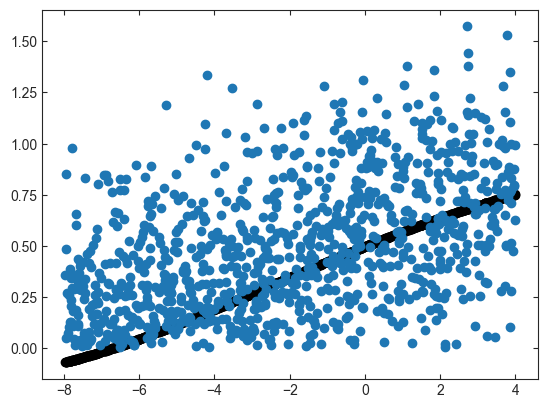

In [7]:
test_sfrs = torch.from_numpy(np.random.uniform(-8, 4, 1000))
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_sfrs)
mean_dust2 = f_preds.sample().numpy()
scatter = np.random.uniform(0.05, 0.4)
plt.scatter(test_sfrs, mean_dust2, c='k')
plt.scatter(test_sfrs, dp.truncated_normal(mean_dust2, scatter, 0.0, 4.0, len(test_sfrs)))

In [8]:
torch.save(trained_model.state_dict(), 'gp_models/dust2.pth')

mean: 0.0428310061436372 std: 0.004518218006590061
[0.375 0.625 0.875 1.125 1.375] [-0.08753168 -0.10014581 -0.15183915 -0.09845836 -0.0688509 ] [0.07661438 0.08545835 0.09464926 0.05446366 0.04250083]


<ErrorbarContainer object of 3 artists>

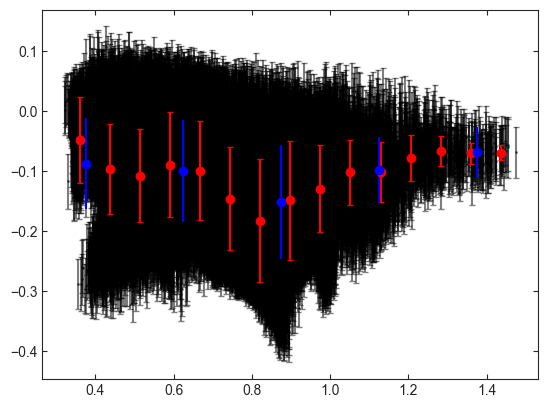

In [9]:
print("mean:", np.mean(ne), "std:", np.std(ne))

bin_means_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(tau, n, 'mean', 15)
bin_std_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(tau, n, 'std', 15)
bin_width_de = (bin_edges_de[1] - bin_edges_de[0])
bin_centers_de = bin_edges_de[1:] - bin_width_de/2

plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
plt.errorbar(tau, n, ne, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)

tau_bins = np.arange(0.25, 4.25, 0.25)
x, y, yerr = binned_weighted_mean_std(tau, n, ne, tau_bins)
print(x, y, yerr)
plt.errorbar(x, y, yerr, fmt='bo')

<ErrorbarContainer object of 3 artists>

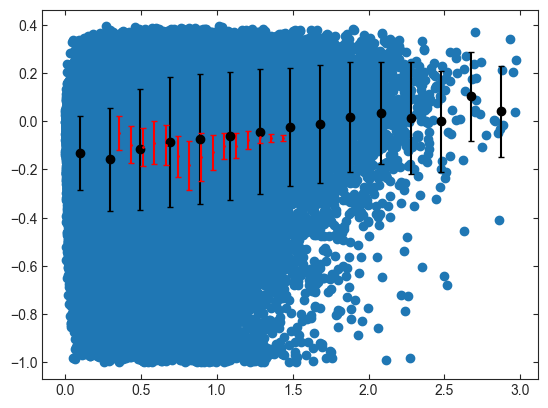

In [10]:
plt.scatter(dust2, dust_index)

bin_means, bin_edges, binnumber = sc.stats.binned_statistic(dust2, dust_index,'mean', 15)
bin_std, bin_edges, binnumber = sc.stats.binned_statistic(dust2, dust_index,'std', 15)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

284.76264454775026
262.8607722244187
240.83104565722158
218.81586522896853
196.97091446654215
175.4637205894722
154.4715852064029
134.17881559209113
114.77319870292705
96.44167698964007
79.36520664847825
63.7128124823969
49.63490738651762
37.25602531819316
26.667230659056575
17.918618478056654
11.012505890205254
5.8981141724532815
2.4687084458130917
0.5622213378629063
-0.03375419052590455
-0.03701841949749404
-0.039890705666107217
-0.042570575802005316
-0.04508037216057989
-0.047438516578649594
-0.04966034098658493
-0.051758726350046406
-0.05374459359499111
-0.05562728146938588
-0.057414838656978856
-0.05911425110364328
-0.06073162044526736
-0.06227230548698454
-0.0637410356778679
-0.06514200325854534
-0.06647893906281284
-0.06775517569074514
-0.06897370083212413
-0.07013720282232563
-0.07124810999550525
-0.07230862501508899
-0.07332075507440063
-0.07428633864510249
-0.07520706928912954
-0.07608451692728692
-0.07692014686468694
-0.07771533680255324
-0.0784713920124331
-0.07918955880881

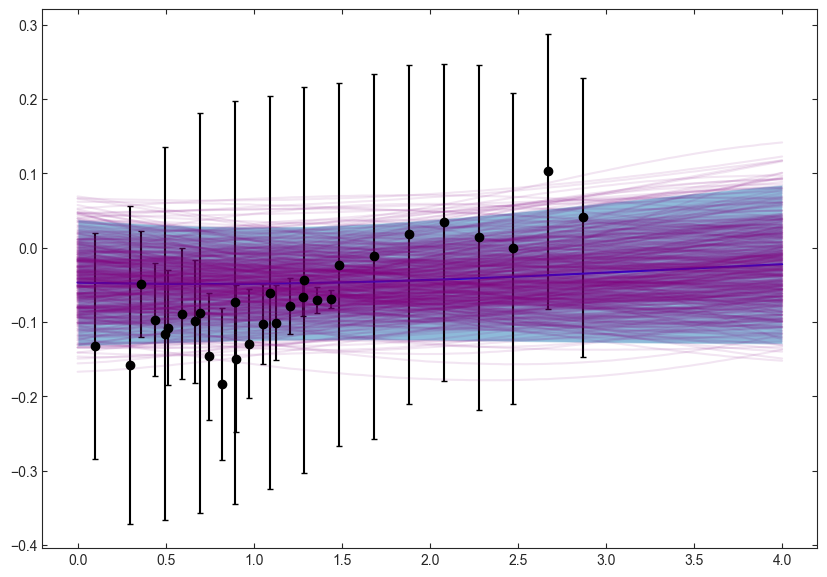

In [11]:
train_dust2 = torch.from_numpy(np.hstack((bin_centers, bin_centers_de)))
train_dust_index = torch.from_numpy(np.hstack((bin_means, bin_means_de)))
train_dust_index_errs = torch.from_numpy(np.hstack((bin_std, bin_std_de)))
test_dust2 = torch.linspace(0, 4, 100)

model, likelihood = create_gp_model_obs([2.0, 6.0], train_dust2, train_dust_index, train_dust_index_errs)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_dust2, train_dust_index, training_iter=10000, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_dust2)
gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust_index, train_dust_index_errs, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(500):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

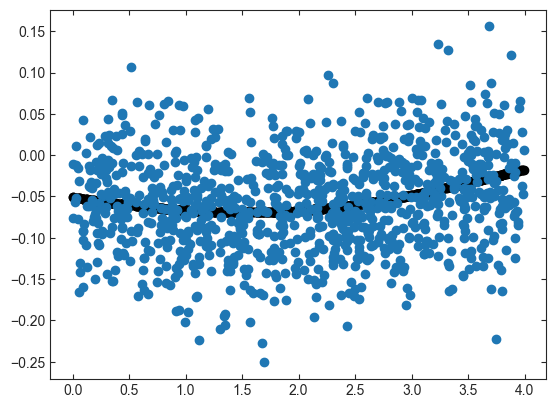

In [12]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 1000))
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_tau)
mean_dust_index = f_preds.sample().numpy()
scatter = np.random.uniform(0.05, 0.4)
plt.scatter(test_tau, mean_dust_index, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust_index, scatter, -2.2, 0.4, len(test_tau)))

mean: 0.0599902575784662 std: 0.010564049578648463
[0.375 0.625 0.875 1.125 1.375] [0.43209103 0.61779893 0.88190412 1.13946773 1.49885674] [0.050582   0.08147123 0.08718599 0.08305305 0.08536868]


<ErrorbarContainer object of 3 artists>

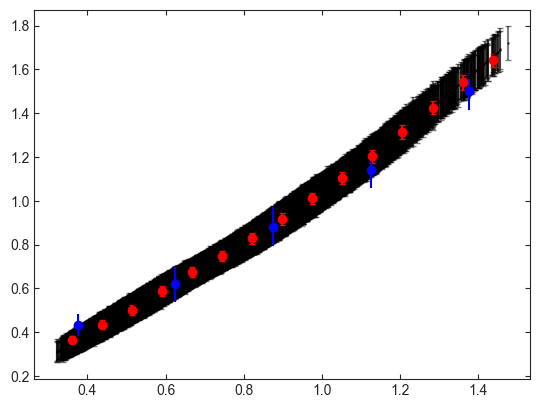

In [13]:
plt.errorbar(tau, tau1, tau1e, fmt='ko', ms=1, capsize=2, alpha=0.5)

print("mean:", np.mean(tau1e), "std:", np.std(tau1e))

bin_means_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(tau, tau1, 'mean', 15)
bin_std_de, bin_edges_de, binnumber_de = sc.stats.binned_statistic(tau, tau1, 'std', 15)
bin_width_de = (bin_edges_de[1] - bin_edges_de[0])
bin_centers_de = bin_edges_de[1:] - bin_width_de/2


plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)

tau_bins = np.arange(0.25, 4.25, 0.25)
x, y, yerr = binned_weighted_mean_std(tau, tau1, tau1e, tau_bins)
print(x, y, yerr)
plt.errorbar(x, y, yerr, fmt='bo')


<ErrorbarContainer object of 3 artists>

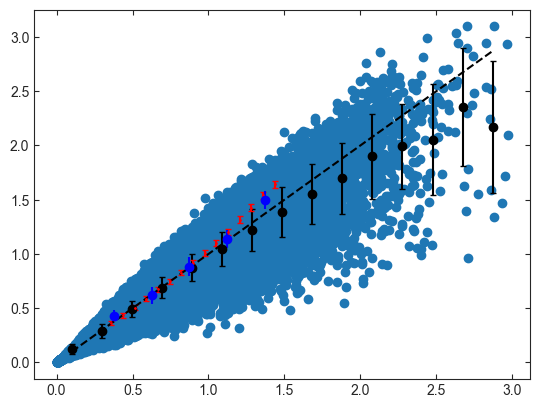

In [14]:
plt.scatter(dust2, dust1)

bin_means, bin_edges, binnumber = sc.stats.binned_statistic(dust2, dust1,'mean', 15)
bin_std, bin_edges, binnumber = sc.stats.binned_statistic(dust2, dust1,'std', 15)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)
plt.plot(bin_centers, bin_centers, c='k', ls='--')
plt.errorbar(x, y, yerr, fmt='bo')

2734.4060382455727
2650.305001172413
2563.463343141757
2474.0702030393795
2382.3451346224247
2288.5376412710343
2192.9260766164743
2095.8158835633426
1997.5371694970258
1898.4416433250165
1798.8989683552493
1699.2926107000771
1600.015283363954
1501.4641003045924
1404.0355626077405
1308.1205010485921
1214.099096308591
1122.336090502193
1033.1762921027287
946.9404617694115
863.9216501290957
784.3820414846475
708.5503408224922
636.6197262472605
568.7463756446502
505.04856521314093
445.6063284858119
390.4616573528017
339.61922102815885
293.04757445330773
250.68082385864506
212.42071372180249
178.1390958522184
147.68073759152003
120.86642206895495
97.49628914504156
77.35336129613151
60.207194527813144
45.817590825142204
33.93830606180798
24.320686103257934
16.71716440429141
10.884556979359408
6.587095344156756
3.5991448684745735
1.7075647618954648
0.7136763052209728
0.43437721199507795
0.4343583146950795
0.43430237389269893
0.434216598582594
0.4341071904222538
0.43397944343991934
0.43383784

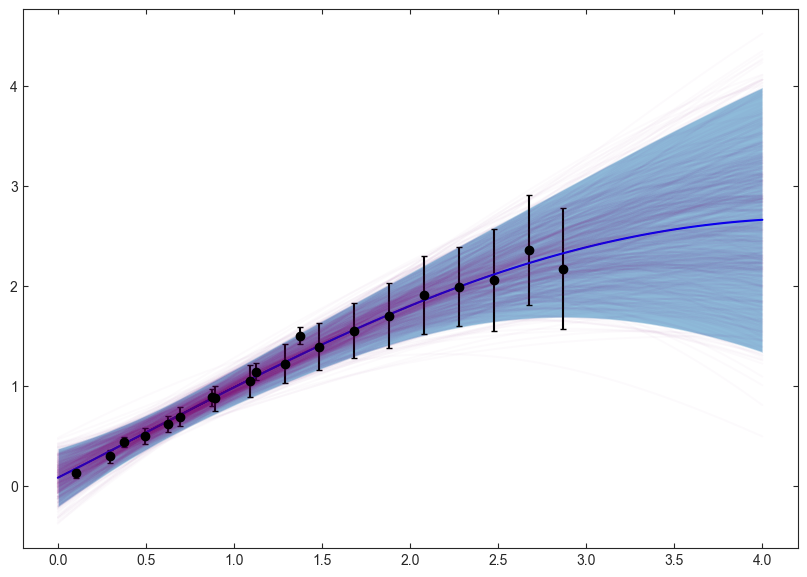

In [15]:
train_dust2 = torch.from_numpy(np.hstack((bin_centers, x)))
train_dust1 = torch.from_numpy(np.hstack((bin_means, y)))
train_dust1_errs = torch.from_numpy(np.hstack((bin_std, yerr)))
test_dust2 = torch.linspace(0, 4, 100)

model, likelihood = create_gp_model_obs([4.0, 10.0], train_dust2, train_dust1, train_dust1_errs)
trained_model, trained_likelihood = gp_training_loop(model, likelihood, train_dust2, train_dust1, training_iter=10000, lr=0.1)
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_dust2)
gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1, train_dust1_errs, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(500):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.02)

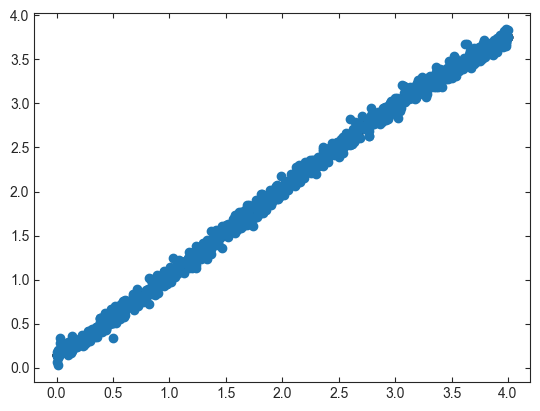

In [16]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 1000))
f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_tau)
mean_dust1 = f_preds.sample().numpy()
scatter = np.random.uniform(0.05, 0.4)
plt.scatter(test_tau, mean_dust1, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust1, scatter, 0.0, 4.0, len(test_tau)))